# v3_cordB.ipynb

A copy of v3_normal where units and connections were removed in order to produce an isolated spinal cord controlling the arm.

The difference with v3_cord.ipynb is that in that notebook the arm is reset with `place_hand` on each simulation, whereas here the whole network is created anew for each simulation.


In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *
from plants import spinal_plants

In [4]:
def create_net(coords):
    """ Create a network with a hand in the given coordinates.
    
    Args:
        coords: list-like with [x,y] coordinates.
        
    Returns:
        net: a network where the initial hand position is the given coordinates.
        pops_dict: a dictionary with the names and unit IDs for all populations. 
    """

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # network and plant parameters
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    net_params = {'min_delay' : 0.005,
                  'min_buff_size' : 10 }
    # Find the angles corresponding to the given coordinates
    L1 =0.3  # upper arm length to create initial angles
    L2 = 0.3 # forearm length
    # copied from coords_to_angs
    x = coords[0]
    y = coords[1]
    Rsq = x*x + y*y
    R = np.sqrt(Rsq)
    if R > L1 + L2:
        raise ValueError('Unreachable coordinate given')
    qe = np.pi - np.arccos((L1**2 + L2**2 - Rsq) / (2.*L1*L2))
    qs = np.arctan2(y,x) - np.arcsin((L2/R)*np.sin(qe))
    P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
              'mass1': 1.,
              'mass2': 1.,
              's_min' : -0.8,
              'p1' : (-0.01, 0.04),
              'p2' : (0.29, 0.03),
              'p3' : (0., 0.05),
              'p5' : (0.01, -0.05),
              'p10': (0.29, 0.03),
              'init_q1': qs,
              'init_q2': qe,
              'init_q1p': 0.,
              'init_q2p': 0.,
              'g': 0.0,
              'mu1': 3.,
              'mu2': 3.,
              'l_torque' : 0.01,
              'l_visco' : 0.01,
              'g_e' : 2.*np.array([10., 20., 20., 10., 20., 20.]),
              'l0_e' : [1.]*6,
              'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
              'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
              'Ib_gain' : 1.,
              'T_0' : 10.,
              'k_pe_e' : 5.,  #8
              'k_se_e' : 25., #13
              'b_e' : 5.,
              'g_s' : 0.02,
              'k_pe_s' : 2., 
              'k_se_s' : 2.,
              'g_d' : 0.01,
              'k_pe_d' : .2, #.1,
              'k_se_d' : 1., #2.,
              'b_s' : .5,
              'b_d' : 2.,#3.,
              'l0_s': .7,
              'l0_d': .8,
              'fs' : 0.1,
              'se_II' : 0.5,
              'cd' : 0.5,
              'cs' : 0.5,
              'tau' : 0.1   # ficticious time constant used in create_freqs_steps
               }
    
    net = network(net_params) # create network

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # UNIT PARAMETER DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    par_heter = 0.001 # range of heterogeneity as a fraction of the original value
    #randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
    randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
    randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
    randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
    randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

    AL_params = {'type' : unit_types.sigmoidal,
                 'thresh' : 0.6 * randz6(),
                 'slope' : 2. * randz6(),
                 'init_val' : 0.1 * randz6(),
                 'tau' : 0.05 * randz6() }
    CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
                 'thresh' : 0. * randz6(),
                 'slope' : 1.5 * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.1, #0.02 * randz6(),
                 'tau_fast': 0.1,
                 'tau_mid' : 1.,
                 'tau_slow' : 50.,
                 'custom_inp_del' : 15, # placeholder values
                 'custom_inp_del2': 30,
                 'integ_amp' : 1.87, #.5,
                 'integ_decay' : 1.33,
                 'adapt_amp' : 10., #8.,
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : 1. }
    CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
                 'thresh' : 0.5 * randz6(),
                 'slope' : 2. * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.05, #0.01 * randz6(), #0.02 * randz6(),
                 'tau_fast': 0.1,
                 'tau_mid' : 1.,
                 'tau_slow' : 50.,
                 'custom_inp_del' : 15, # placeholder values
                 'custom_inp_del2': 30,
                 'integ_amp' : 1.87, #.5,
                 'integ_decay' : 1.33,
                 'adapt_amp' : 10., #8.,
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : 1. }
    INP_params = {'type' : unit_types.source,
                  'init_val' : 0.5,
                  'tau_fast' : 0.02,
                  'tau_mid' : 0.1,
                  'function' : lambda t: None }
    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTION DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # AL to P ------------------------------------------------
    AL__P_conn = {'inp_ports' : list(range(6)),
                 'delays': 0.01 }
    AL__P_syn = {'type': synapse_types.static,
                'init_w' : 1. }
    # CE, CI to AL ----------------------------------------------
    CE__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__AL_syn = {'type' : synapse_types.static,
                  'init_w' : [1., 1., 1., 1., 1., 1.] }
    CI__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__AL_syn = {'type' : synapse_types.static,
                  'init_w' : -1. }
    # CE,CI to CE,CI  ------------------------------------------------
    CE__CI_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__CE_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 1. }
    CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
                  'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'lrate' : .0,
                  'des_act' : 0.5,
                  'init_w' : -4. }
    C__C_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.015 }
    C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                      'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                      'init_w' : 2., #16.,
                      'lrate' : 1.,
                      'des_act' : .5 }
    C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                      'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                      'init_w' : .5, # 8.,
                      'lrate' : 1.,
                      'des_act' : 0.2 }
    C__C_syn_syne = {'type' : synapse_types.static,
                     'inp_ports': 1,
                     'lrate' : 1.,
                     'init_w' : .5 }
    C__C_syn_p_syne = {'type' : synapse_types.static,
                       'inp_ports': 1,
                       'lrate' : 1.,
                       'init_w' : 0.2 }
    C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                       'inp_ports': 1,
                       'lrate' : 1.,
                       'init_w' : 0. }
    C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                       'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                       'lrate' : 1.,
                       'init_w' : 0. }
    INP_CE_conn = {'rule' : 'all_to_all',
                'delay' : 0.01 }
    INP_CE_syn = {'type' : synapse_types.static,
                 'inp_ports': 0,
                 'init_w' : 0.0 } # these are changed by get_dir_field()
    INP_CI_conn = {'rule' : 'all_to_all',
                'delay' : 0.01 }
    INP_CI_syn = {'type' : synapse_types.static,
                 'inp_ports': 0,
                 'init_w' : 0.0 } # these are changed by get_dir_field()

    #*************************************************************

    # PARAMETER CHANGES
    #AL__P_syn['init_w'] = 0.
    #CE__AL_syn['init_w'] = 0.
    #CI__AL_syn['init_w'] = 0.
    CE_params['tau'] = 0.02
    CI_params['tau'] = 0.1
    P_params['k_pe_e'] = 50.
    P_params['k_se_e'] = 40.
    P_params['g_e'] = 1.5*np.array([17., 20., 18., 15., 20., 20.])

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATING UNITS
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    AL = net.create(6, AL_params)
    CE = net.create(6, CE_params)
    CI = net.create(6, CI_params)
    INP = net.create(1, INP_params)
    P = net.create(1, P_params)

    ipx_track = net.create(12, track_params) # x coordinates of insertion points
    ipy_track = net.create(12, track_params) # y coordinates of insertion points

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTING
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # from CE to AL
    net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
    # from CI to AL
    net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
    # from AL to P
    net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
    # intraspinal connections
    # We organize the spinal connections through 4 types of symmetric relations
    # these lists are used to set intraspinal connections and test connection matrices
    antagonists = [(0,3), (1,2), (4,5)]
    part_antag = [(0,2),(0,5), (3,4), (1,3)]
    synergists = [(0,1), (0,4), (2,3), (3,5)]
    part_syne = [(1,4), (2,5)]
    self_conn = [(x,x) for x in range(6)]
    # adding the symmetric relation (inverting source and target)
    antagonists += [(p[1],p[0]) for p in antagonists]
    part_antag += [(p[1],p[0]) for p in part_antag]
    synergists += [(p[1],p[0]) for p in synergists]
    part_syne += [(p[1],p[0]) for p in part_syne]
    all_pairs = [(i,j) for i in range(6) for j in range(6)]
    #unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)
    for pair in all_pairs:
        if pair in synergists:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in part_syne:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in antagonists:
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in part_antag:
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in self_conn:
            net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
            net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
        else:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)       
    # from INP to CE,CI
    net.connect(INP, CE, INP_CE_conn, INP_CE_syn)
    net.connect(INP, CI, INP_CI_conn, INP_CI_syn)

    # SETTING THE FUNCTION FOR INP
    net.units[INP[0]].set_function(lambda t: 1.) #if t > 0.2 else 0.)

    # TRACKING OF INSERTION POINTS (for the arm animation)
    # make the source units track the tensions
    def create_xtracker(arm_id, idx):
        return lambda t: net.plants[arm_id].ip[idx][0]
    def create_ytracker(arm_id, idx):
        return lambda t: net.plants[arm_id].ip[idx][1]
    for idx, uid in enumerate(ipx_track):
        net.units[uid].set_function(create_xtracker(P, idx))
    for idx, uid in enumerate(ipy_track):
        net.units[uid].set_function(create_ytracker(P, idx))
        
    # TEST OF ARM LENGTHS
    l1 = net.plants[0].l_arm # length of upper arm
    l2 = net.plants[0].l_farm # length of forearm
    assert (l1 == L1) and (l2 == L2), "L1, L2 arm lengths are inconsistent"

    pops_list = [AL, CE, CI, INP, P, ipx_track, ipy_track]
    pops_names = ['AL','CE', 'CI', 'INP', 'P', 'ipx_track', 'ipy_track']
    pops_dict = {pops_names[idx] : pops_list[idx] for idx in range(len(pops_names))}
    return net, pops_dict

In [5]:
# A method to obtain a direction field for given stimulated populations
def get_dir_field(stim_pops, sim_time, CE_w=1., CI_w=1.):
    """ Given a list of spinal units to stimulate, return a direction field.
    
        Args:
            stim_pops: a list with the indexes of CE/CI units to stimulate.
            sim_time: time to run the simulations.
            CE_w: synaptic weight for connections from input to CE (default 1)
            CI_w: synaptic weight for connections from input to CI (default 1)
            
        Returns:
            A 5-tuple with these arrays, in this order:
                hand_coords: each row contains initial hand coordinates
                final_hand_coordinates: each row contains corresponding final hand coordinates.
                times: numpy array with the times for the data arrays in `all_data`, `all_plant_data`
                all_data: list with a 'data' array for every hand position in hand_coords.
                all_plant_data: list with a 'plant_data' array for each hand position.
    """
    #1) Choose a grid of initial hand coordinates
    min_s_ang = -0.2 # minimum shoulder angle
    max_s_ang = 0.9  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    s_subs = 8 # number of shoulder angle subdivisions in grid
    e_subs = 8 # number of elbow angle subdivisions in grid
    n_coords = s_subs * e_subs # number of coordinates to generate
    net, pops_dict = create_net([0.3,0.3]) # create a reference network
    l_arm = net.plants[0].l_arm # length of upper arm
    l_farm = net.plants[0].l_farm # length of forearm
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = np.linspace(min_s_ang, max_s_ang, s_subs)
    e_angs = np.linspace(min_e_ang, max_e_ang, s_subs)
    #s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    #e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    all_s_angs = np.tile(s_angs,(e_subs,1)).transpose().flatten()
    all_e_angs = np.tile(e_angs,(1,s_subs)).flatten()
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(all_s_angs[i]) + l_farm*np.cos(all_s_angs[i]+all_e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(all_s_angs[i]) + l_farm*np.sin(all_s_angs[i]+all_e_angs[i]) # y-coordinate
    hand_coords = np.array(hand_coords)
  
    # 2) Run a simulation for each grid point
    all_data = []
    all_plant_data = []
    final_hand_coords = np.zeros_like(hand_coords)
    for c_idx, hcoords in enumerate(hand_coords):
        # 2.1) Initialize
        net, pops_dict = create_net(hcoords)
        CE = pops_dict['CE']
        CI = pops_dict['CI']
        #P = pops_dict['P']
        INP = pops_dict['INP']
        # 2.1.1) Set inputs to spinal units
        CE_stim = [CE[i] for i in stim_pops] # list of ID's of CE units to stimulate
        CI_stim = [CI[i] for i in stim_pops] # list of ID's of CI units to stimulate
        for ce in CE_stim:
            for syn in net.syns[ce]:
                if syn.preID == INP[0]:
                    syn.w = CE_w
        for ci in CI_stim:
            for syn in net.syns[ci]:
                if syn.preID == INP[0]:
                    syn.w = CI_w
        # 2.2) Run sim, save final hand coordinates
        start_time = time.time()
        times, data, plant_data  = net.flat_run(sim_time)
        #times, data, plant_data  = net.run(sim_time)
        print('sim %d: %s seconds' % (c_idx, time.time() - start_time),end=", ")
        if c_idx % 4 == 0: print("...")
        ## converting lists to arrays, and reducing size
        data = np.array(data); data = data[:,::10]; 
        plant_data = np.array(plant_data); plant_data = plant_data[0][::10,:]
        all_data.append(data)
        all_plant_data.append(plant_data)

        # 2.3) Extract final hand locations
            # angles of shoulder and elbow
        theta_s = plant_data[-1,0]
        theta_e = plant_data[-1,2]
        phi = theta_s + theta_e # elbow angle wrt x axis
            # coordinates of hand and elbow
        xe = np.cos(theta_s)*l_arm
        ye = np.sin(theta_s)*l_arm
        xh = xe + np.cos(phi)*l_farm
        yh = ye + np.sin(phi)*l_farm
        final_hand_coords[c_idx,:] = np.array([xh, yh])
        
    return (hand_coords, final_hand_coords, times[::10], all_data, all_plant_data)


In [6]:
# run simulations
sim_time = .5 # 1. Gives the closest match
E_amp = 1. # amplitude of stimulus to CE population
I_amp = .1 # amplitude of stimulus to CI population
# no C units are stimulated
hand_coords0, final_hand_coords0, t0, ad0, apd0 = get_dir_field([], sim_time, CE_w=E_amp, CI_w=I_amp)
# A couple of flexor units stimulated
hand_coords1, final_hand_coords1, t1, ad1, apd1 = get_dir_field([2,3], sim_time, CE_w=E_amp, CI_w=I_amp)
# A couple of extensor units stimulated
hand_coords2, final_hand_coords2, t2, ad2, apd2 = get_dir_field([0,1], sim_time, CE_w=E_amp, CI_w=I_amp)
# Both flexor and extensor units stimulated
hand_coords3, final_hand_coords3, t3, ad3, apd3 = get_dir_field([0, 1, 2, 3], sim_time, CE_w=E_amp, CI_w=I_amp)
print("done!")

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


sim 0: 0.674912691116333 seconds, ...
sim 1: 0.4159586429595947 seconds, sim 2: 0.41108131408691406 seconds, sim 3: 0.4121997356414795 seconds, sim 4: 0.40569257736206055 seconds, ...
sim 5: 0.4060943126678467 seconds, sim 6: 0.40619611740112305 seconds, sim 7: 0.40538477897644043 seconds, sim 8: 0.6458919048309326 seconds, ...
sim 9: 0.41704869270324707 seconds, sim 10: 0.41127896308898926 seconds, sim 11: 0.4113762378692627 seconds, sim 12: 0.4069383144378662 seconds, ...
sim 13: 0.40497851371765137 seconds, sim 14: 0.4079887866973877 seconds, sim 15: 0.4071958065032959 seconds, sim 16: 0.611821174621582 seconds, ...
sim 17: 0.4182157516479492 seconds, sim 18: 0.4116222858428955 seconds, sim 19: 0.4075930118560791 seconds, sim 20: 0.4056127071380615 seconds, ...
sim 21: 0.40720653533935547 seconds, sim 22: 0.4055500030517578 seconds, sim 23: 0.40558934211730957 seconds, sim 24: 0.4356095790863037 seconds, ...
sim 25: 0.4154648780822754 seconds, sim 26: 0.41353321075439453 seconds, si

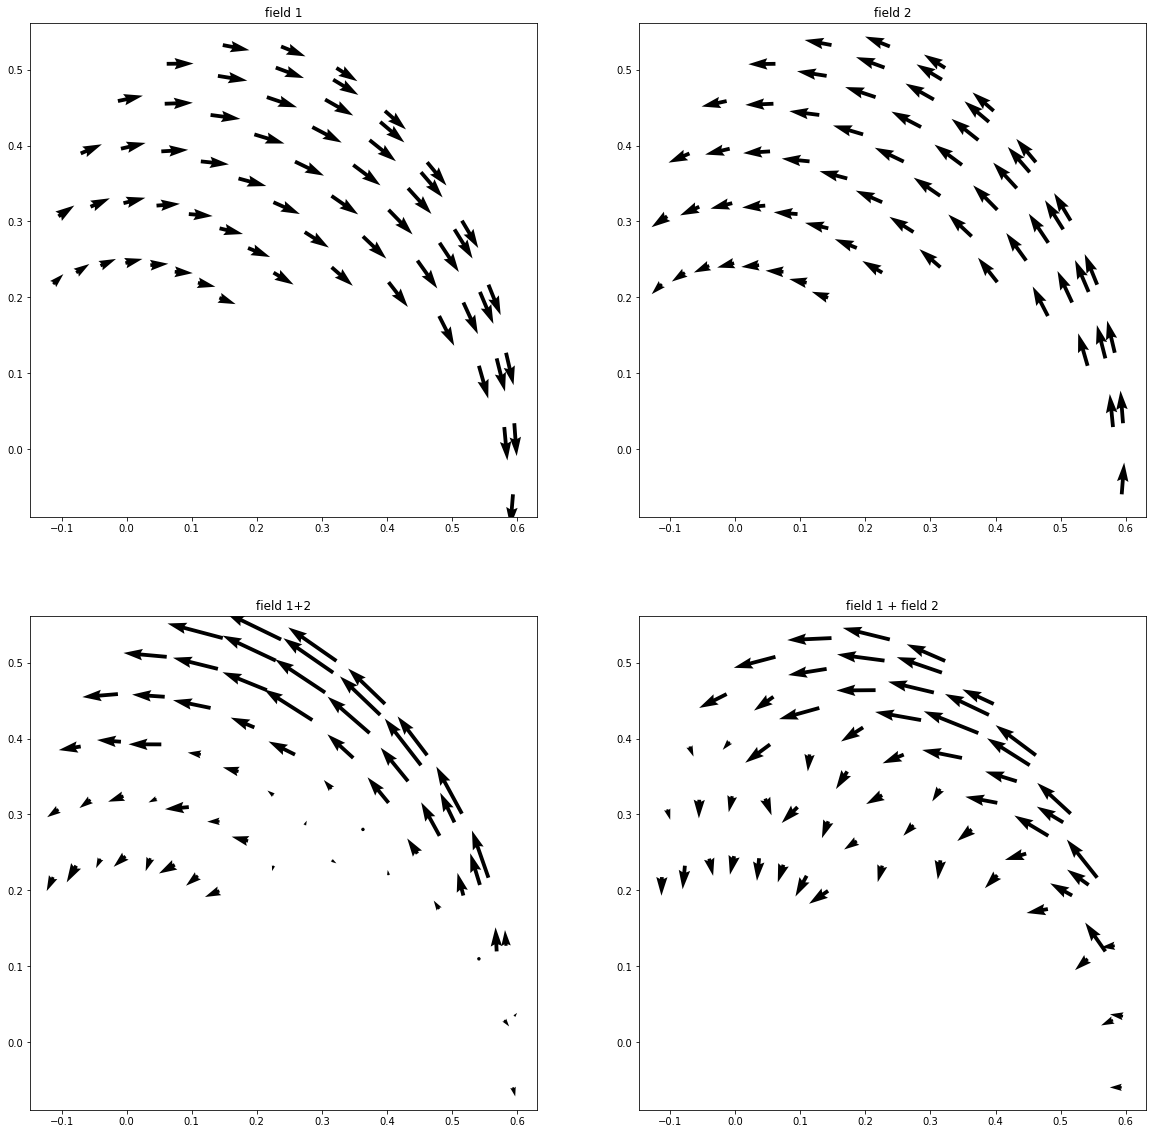

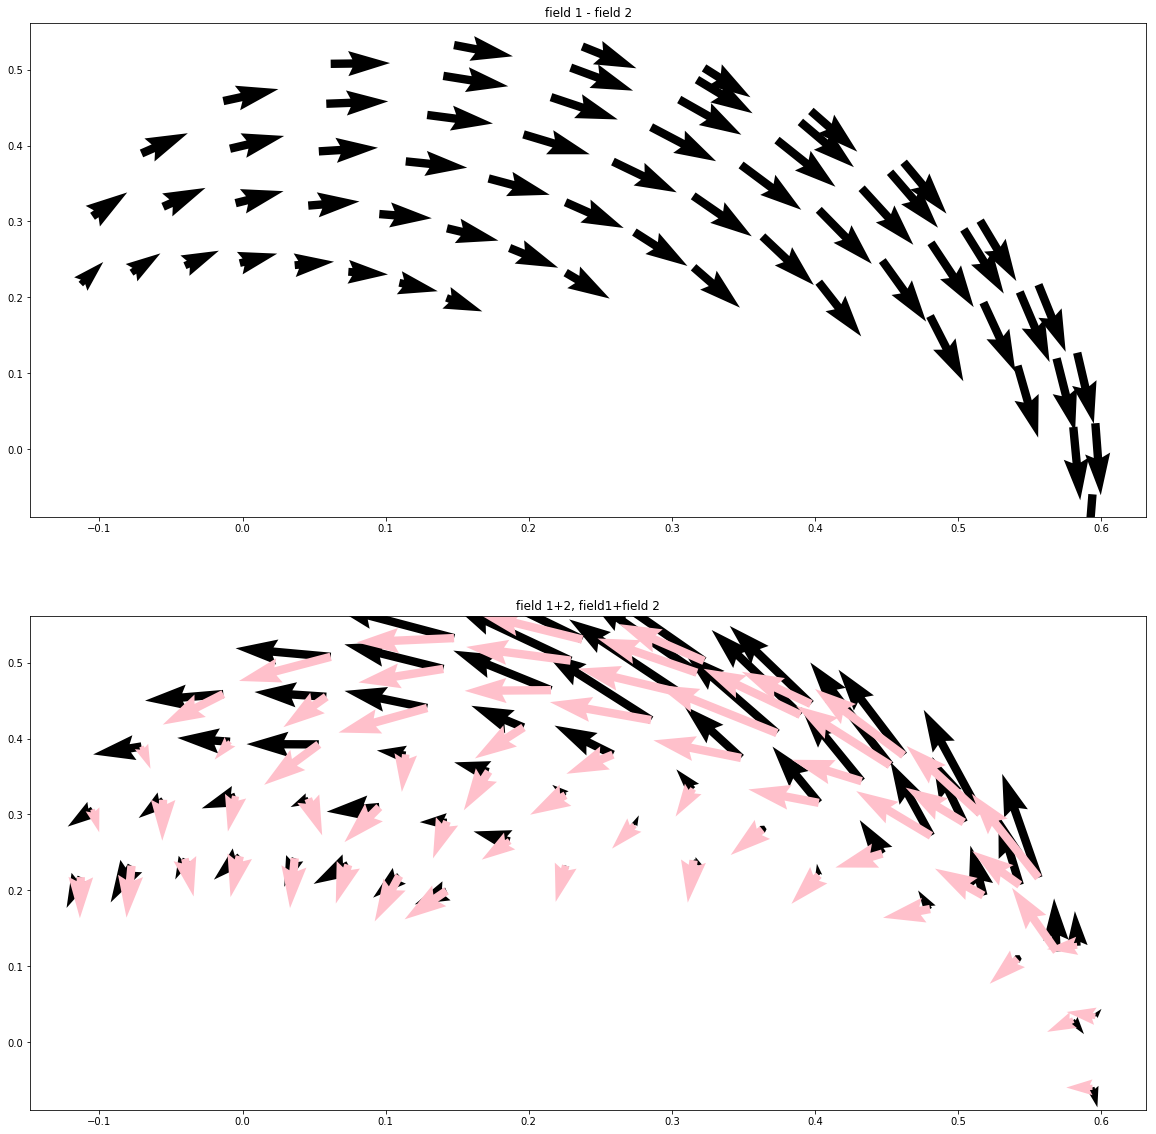

In [10]:
# plot directionsfields. Version with resting field removed.
dirs0 = final_hand_coords0 - hand_coords0
dirs1 = final_hand_coords1 - hand_coords1 - dirs0
dirs2 = final_hand_coords2 - hand_coords2 - dirs0
dirs3 = final_hand_coords3 - hand_coords3 - dirs0
dirs4 = dirs1 + dirs2
dir_fig, dir_axes = plt.subplots(2,2,figsize=(20,20))
q1 = dir_axes[0,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
dir_axes[0,0].set_title("field 1")
q2 = dir_axes[0,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1])
dir_axes[0,1].set_title("field 2")
q3 = dir_axes[1,0].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
dir_axes[1,0].set_title("field 1+2")
q4 = dir_axes[1,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs4[:,0], dirs4[:,1])
dir_axes[1,1].set_title("field 1 + field 2")
    
dir_fig2, dir_axes2 = plt.subplots(2,1,figsize=(20,20))
q1 = dir_axes2[0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0]-dirs2[:,0], dirs1[:,1]-dirs2[:,1])
dir_axes2[0].set_title("field 1 - field 2")
q2 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
q3 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='pink')
dir_axes2[1].set_title("field 1+2, field1+field 2")
plt.show()

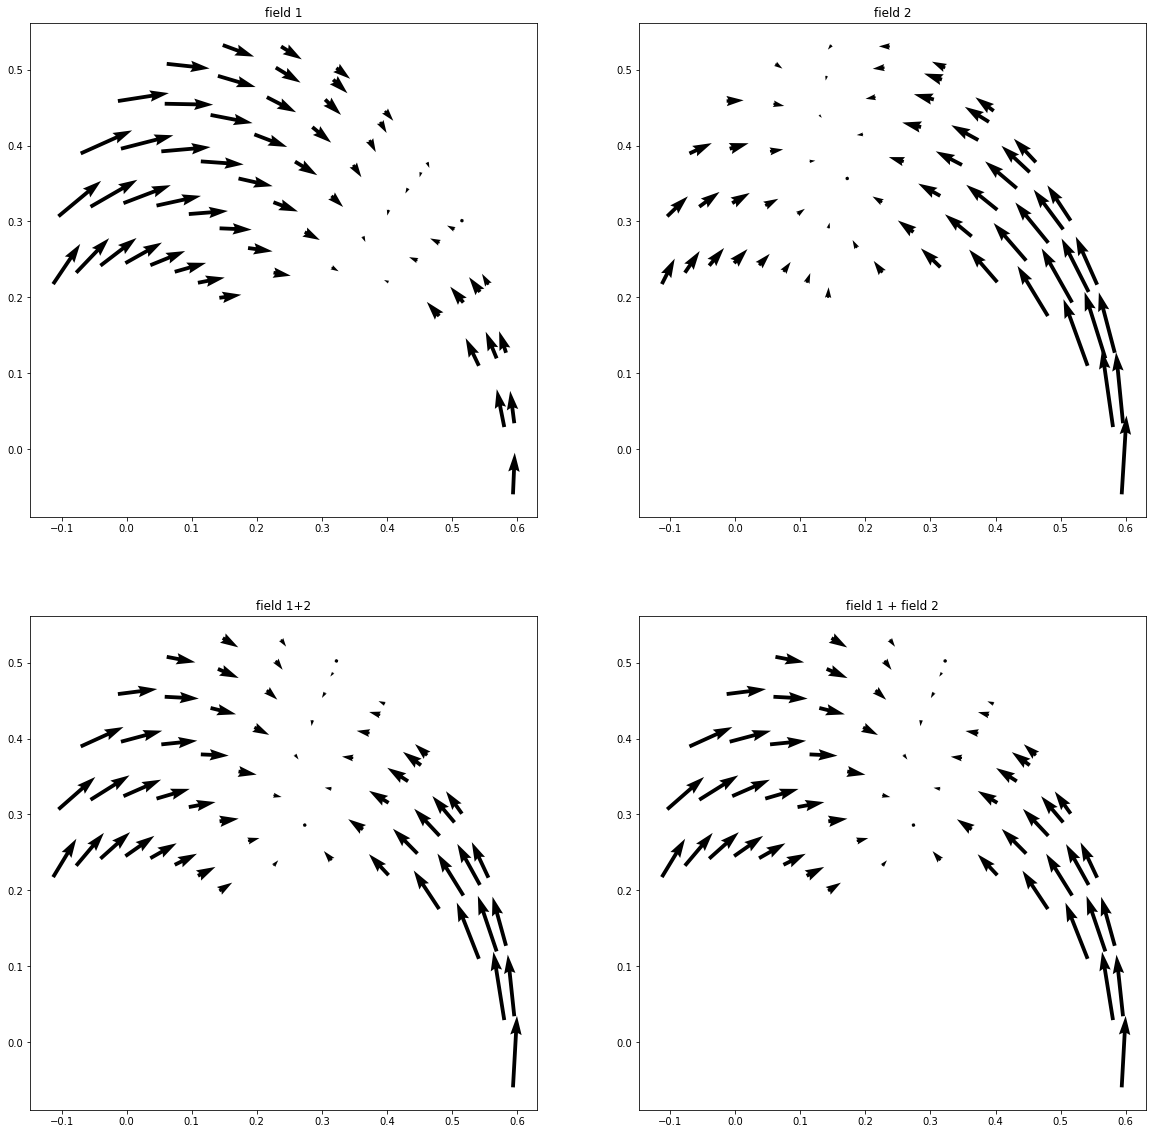

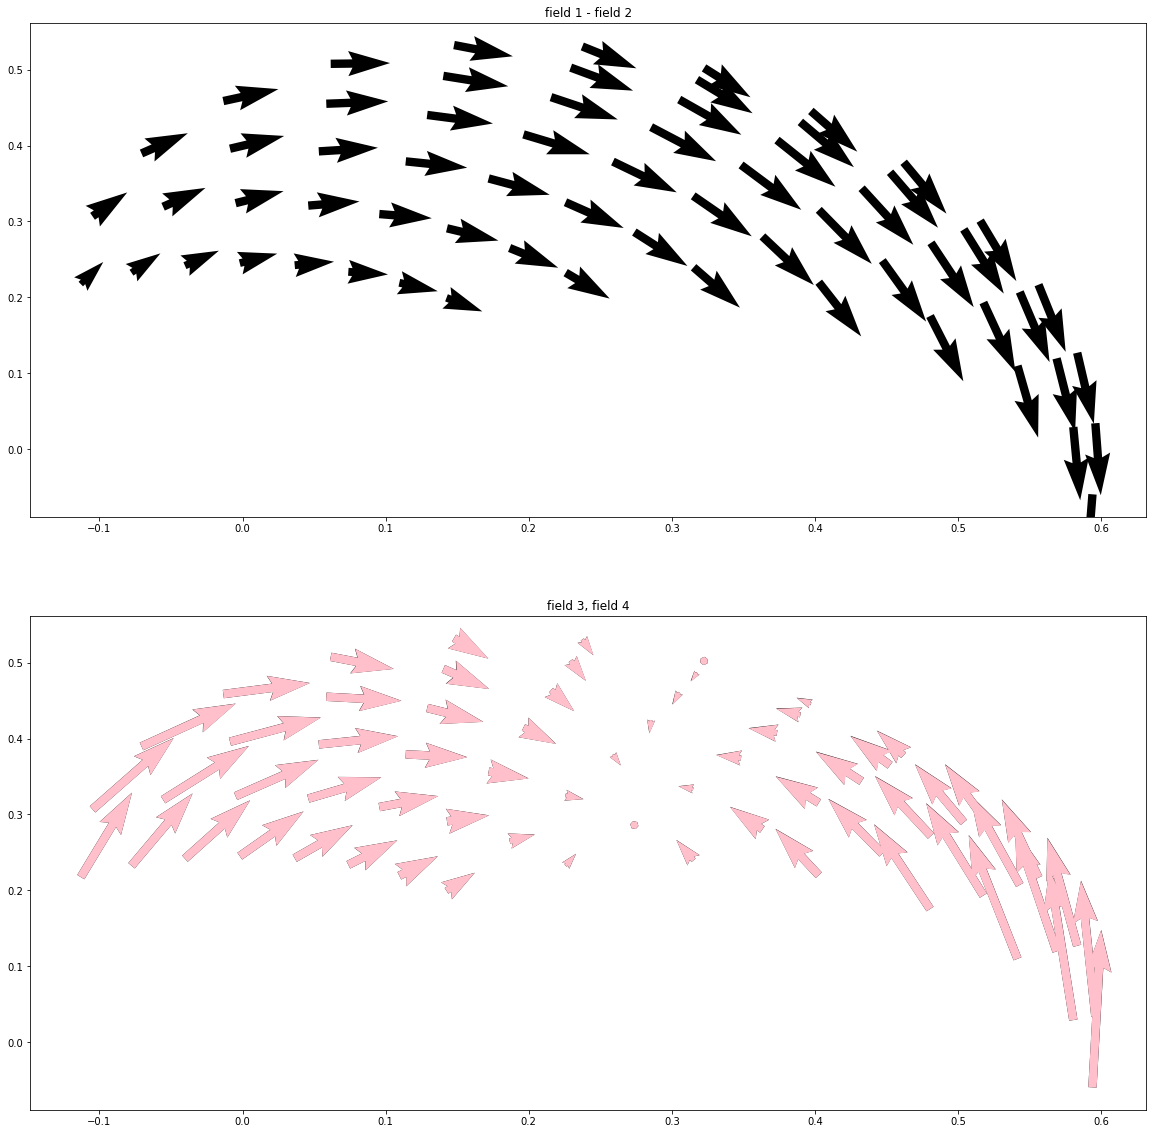

In [8]:
# plot direction fields.
dirs0 = final_hand_coords0 - hand_coords0
dirs1 = final_hand_coords1 - hand_coords1
dirs2 = final_hand_coords2 - hand_coords2
dirs3 = final_hand_coords3 - hand_coords3
dirs4 = dirs1 + dirs2
dir_fig, dir_axes = plt.subplots(2,2,figsize=(20,20))
q1 = dir_axes[0,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
dir_axes[0,0].set_title("field 1")
q2 = dir_axes[0,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1])
dir_axes[0,1].set_title("field 2")
q3 = dir_axes[1,0].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
dir_axes[1,0].set_title("field 1+2")
q4 = dir_axes[1,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs4[:,0], dirs4[:,1])
dir_axes[1,1].set_title("field 1 + field 2")

dir_fig2, dir_axes2 = plt.subplots(2,1,figsize=(20,20))
q1 = dir_axes2[0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0]-dirs2[:,0], dirs1[:,1]-dirs2[:,1])
dir_axes2[0].set_title("field 1 - field 2")
q2 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
q3 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='pink')
dir_axes2[1].set_title("field 3, field 4")
plt.show()


In [11]:
# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Average angle: %f radians" % (avg_ang))
print("Average angle: %f degrees" % (180.*avg_ang/np.pi))

Average angle: 0.862313 radians
Average angle: 49.406918 degrees


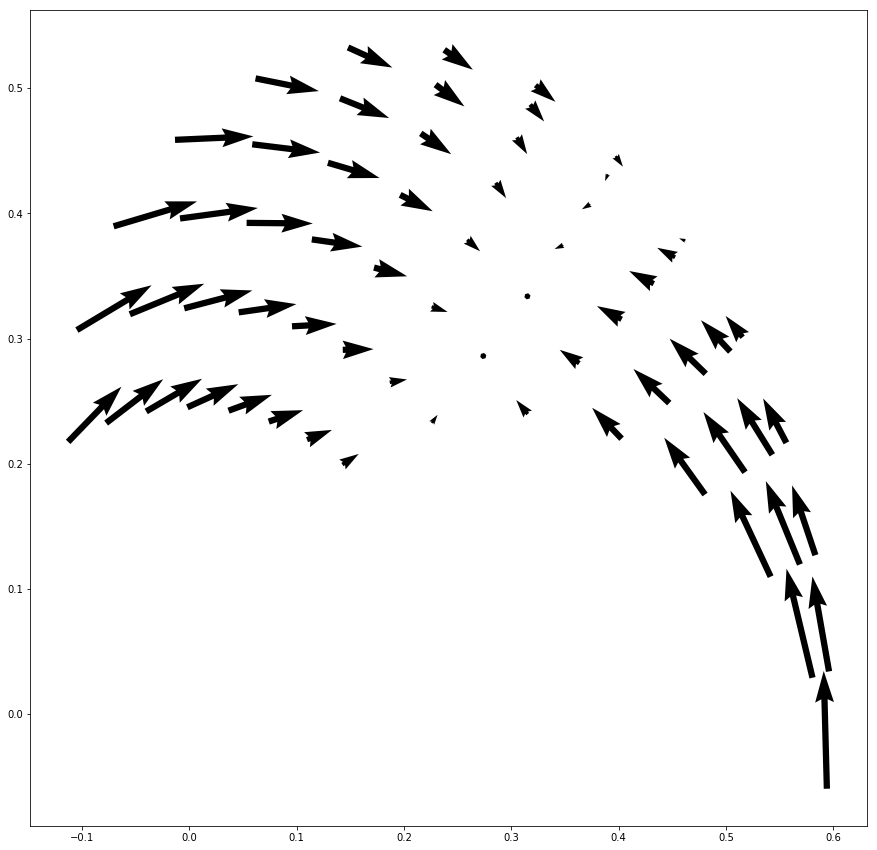

In [6]:
# plot direction field
dirs = final_hand_coords - hand_coords
dir_fig, dir_ax = plt.subplots((2,1),figsize=(15,25))
q = dir_ax.quiver(hand_coords[:,0], hand_coords[:,1], dirs[:,0], dirs[:,1])
plt.show()

In [5]:
# SIMPLE SIMULATION
start_time = time.time()
times, data, plant_data  = net.flat_run(100.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 80.8308777809143 seconds


In [25]:
plant_data = all_plant_data[1]
theta_s = plant_data[:,0]
theta_e = plant_data[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow    
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
print("xh[0]=%f, yh[0]=%f"%(xh[0],yh[0]))
print("xh[-1]=%f, yh[-1]=%f"%(xh[-1],yh[-1]))

xh[0]=0.596426, yh[0]=-0.029433
xh[-1]=0.583874, yh[-1]=0.043188


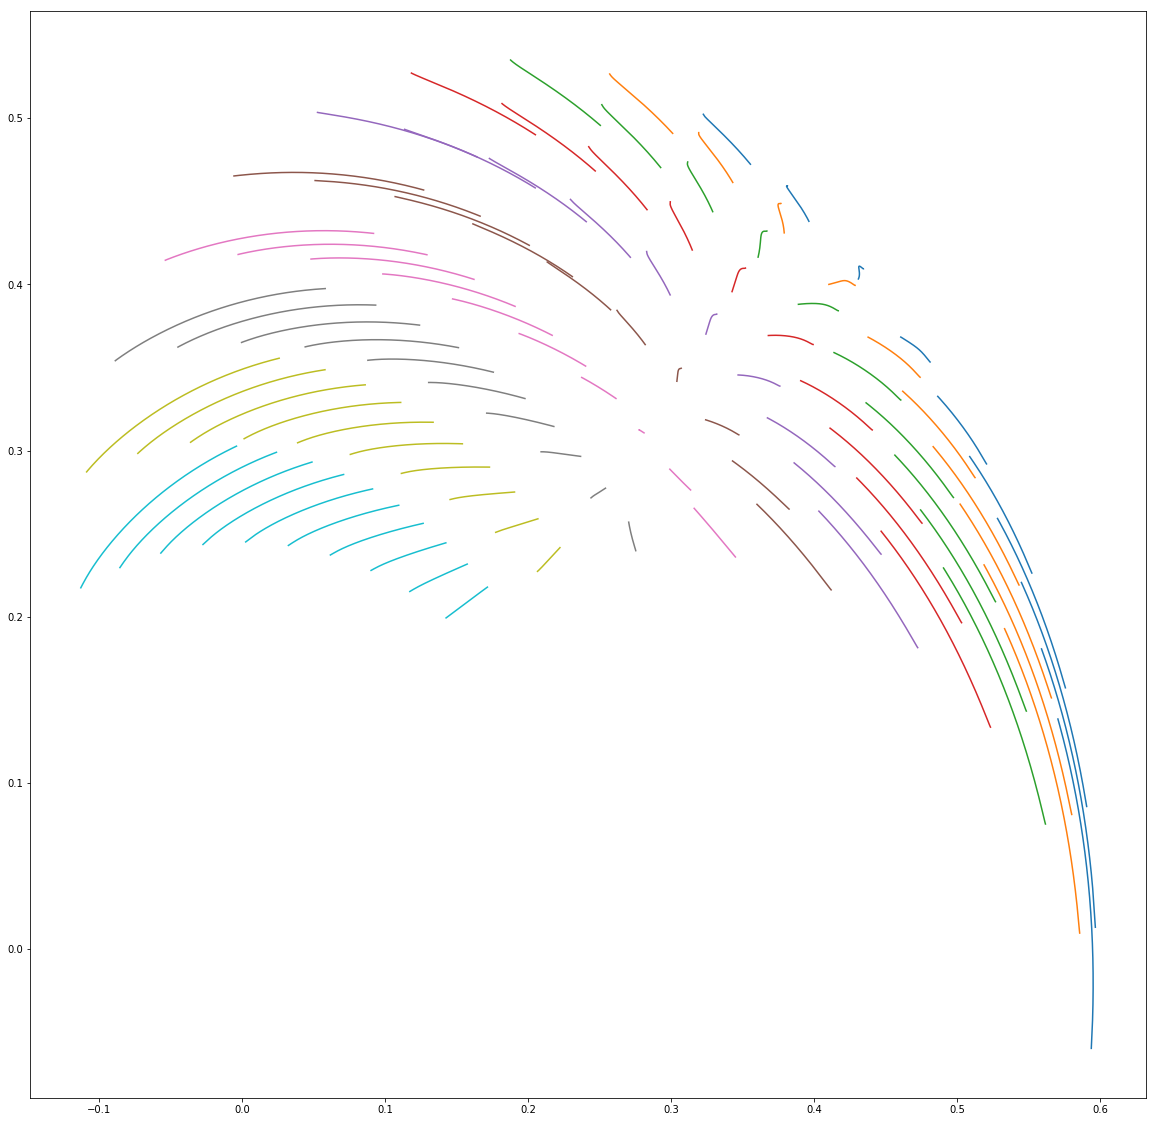

In [8]:
# plot trajectories

l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
fig = plt.figure(figsize=(20,20))
for plant_data in all_plant_data:
    # angles of shoulder and elbow
    theta_s = plant_data[:,0]
    theta_e = plant_data[:,2]
    phi = theta_s + theta_e # elbow angle wrt x axis
    # coordinates of hand and elbow    
    xe = np.cos(theta_s)*l1
    ye = np.sin(theta_s)*l1
    xh = xe + np.cos(phi)*l2
    yh = ye + np.sin(phi)*l2
    plt.plot(xh,yh)
plt.show()
    

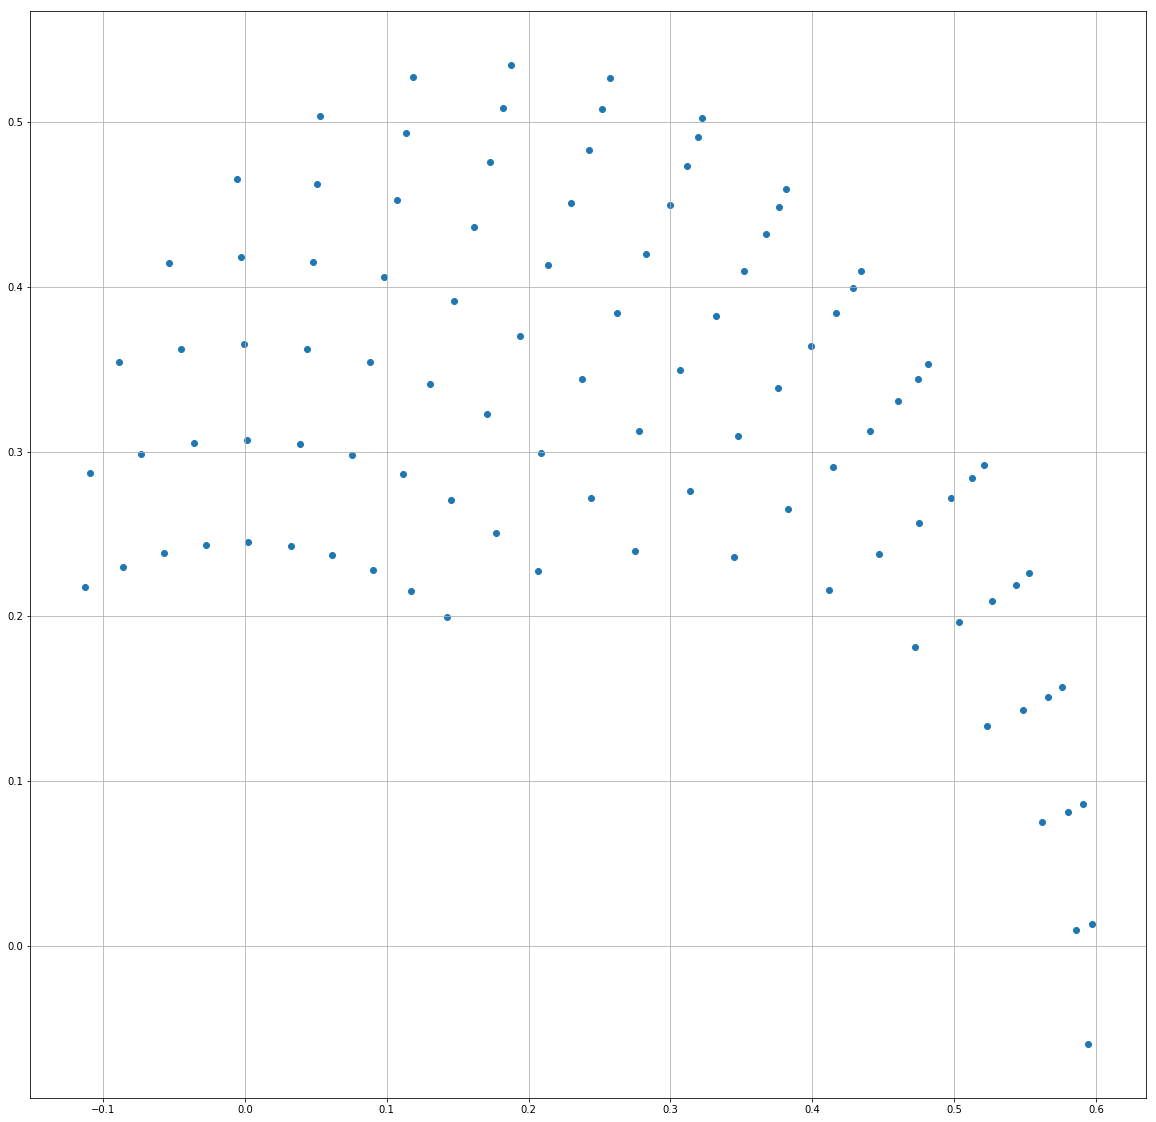

In [8]:
# plot da grid
grid_fig = plt.figure(figsize=(20,20))
plt.scatter(hand_coords[:,0], hand_coords[:,1])
plt.grid()
plt.show()

In [18]:
CI_data.shape

(6, 20)

shoulder angle: -0.163033, shoulder vel: 0.225485


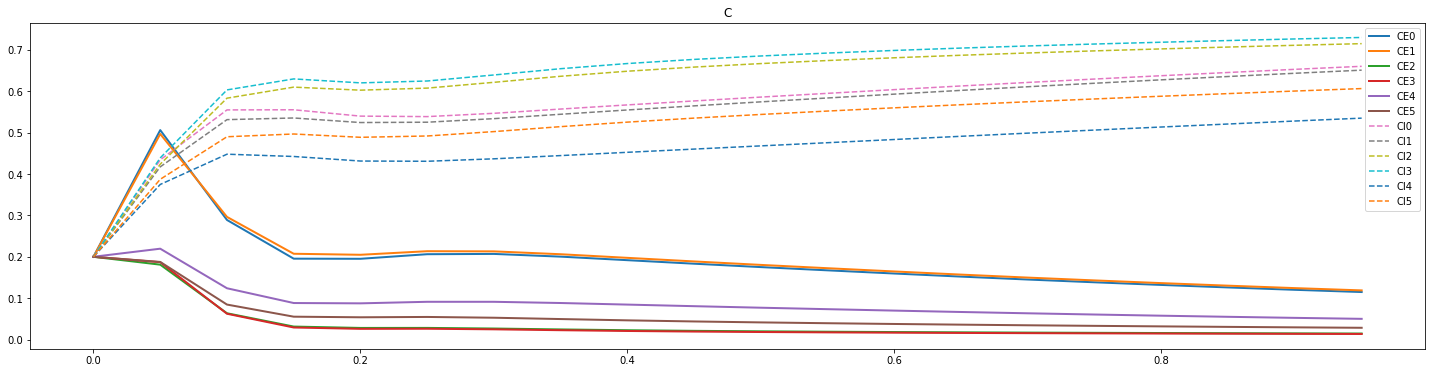

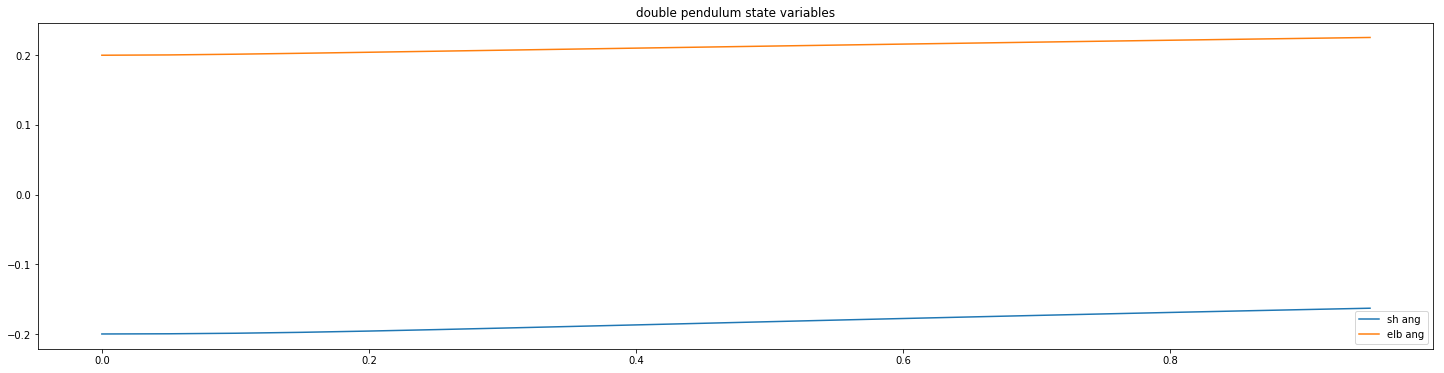

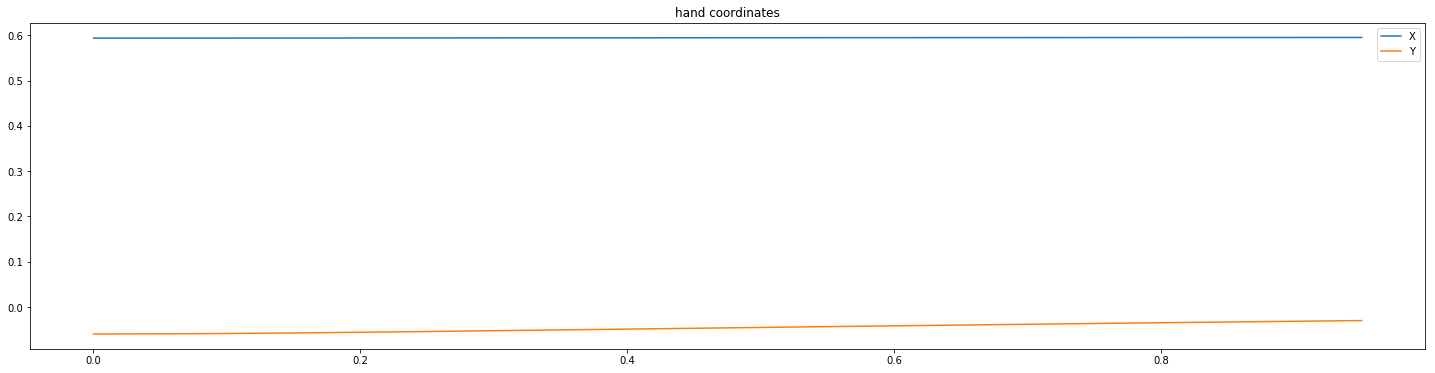

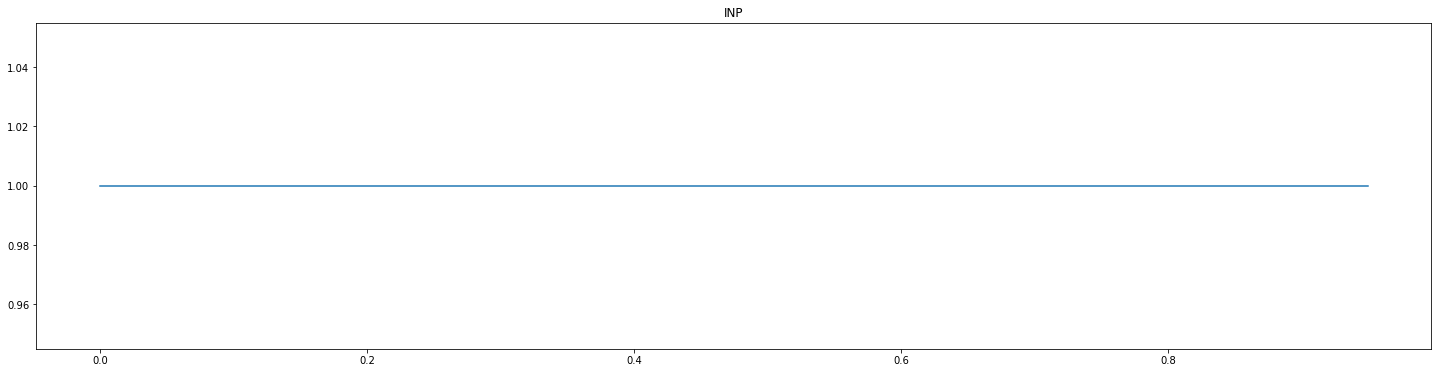

In [11]:
# plotting some unit activities
net, pops_dict = create_net([0.3,0.3])
for name in list(pops_dict.keys()):
    exec("%s = %s"% (name, str(pops_dict[name])))

field = 2 # for which set of simulations (for which stimulus)
grid_point = 0 # for which grid point
ad = [ad0, ad1, ad2, ad3]
apd = [apd0, apd1, apd2, apd3]
plant_data = apd[field][grid_point]
arm_activs = plant_data
data = ad[field][grid_point]
times = t0 # all times grids should be equal

fs = (25,6)
# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)

plt.title('hand coordinates')
plt.legend(['X', 'Y'])

inp_fig = plt.figure(figsize=fs)
inp_data = np.array(data[INP])[0]
plt.plot(times, inp_data)
#plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('INP')

plt.show()

AL_data:
[0.09459524 0.09688838 0.0698076  0.06771188 0.10451283 0.08805473]
Ib avg for muscle 0= 0.2069679335115469
Ia avg for muscle 0= 0.1663037853918672
II avg for muscle 0= 0.40536254806265
Ib avg for muscle 1= 0.16201996203325297
Ia avg for muscle 1= 0.14784822597090444
II avg for muscle 1= 0.3207647856650727
Ib avg for muscle 2= 0.07357584842059608
Ia avg for muscle 2= 0.07397702485505026
II avg for muscle 2= 0.1509413773873288
Ib avg for muscle 3= 0.009626465957601412
Ia avg for muscle 3= 0.052385960156627664
II avg for muscle 3= 0.16534040504223207
Ib avg for muscle 4= 0.20704204190710582
Ia avg for muscle 4= 0.2877565902594185
II avg for muscle 4= 0.5114483408040852
Ib avg for muscle 5= 0.0686637715356008
Ia avg for muscle 5= -0.029581493877661104
II avg for muscle 5= 0.013089030301094368


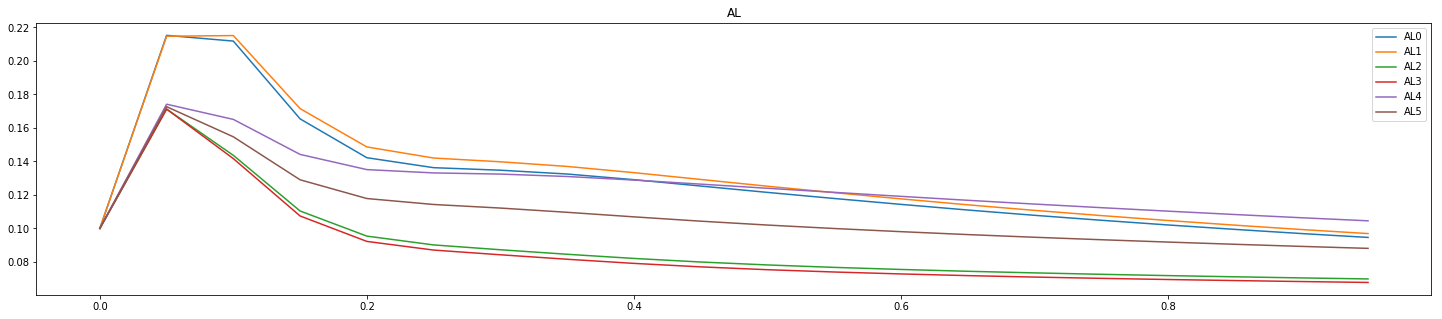

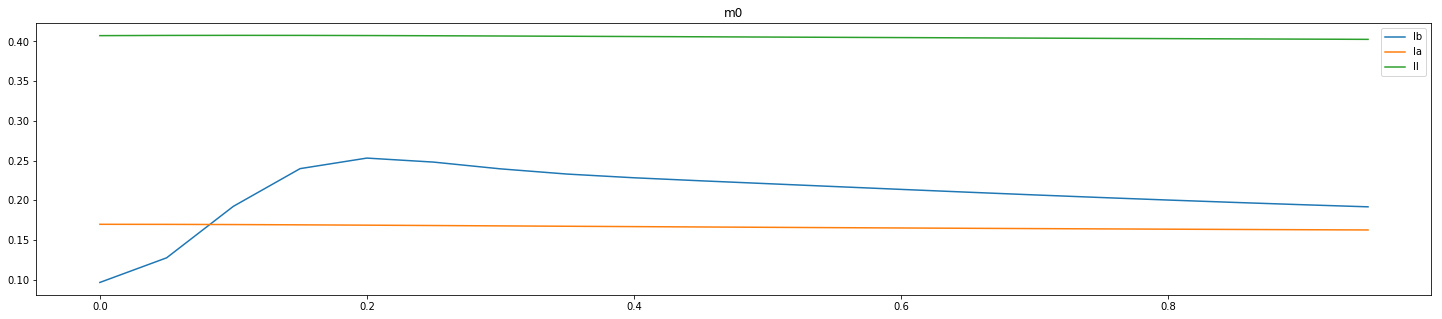

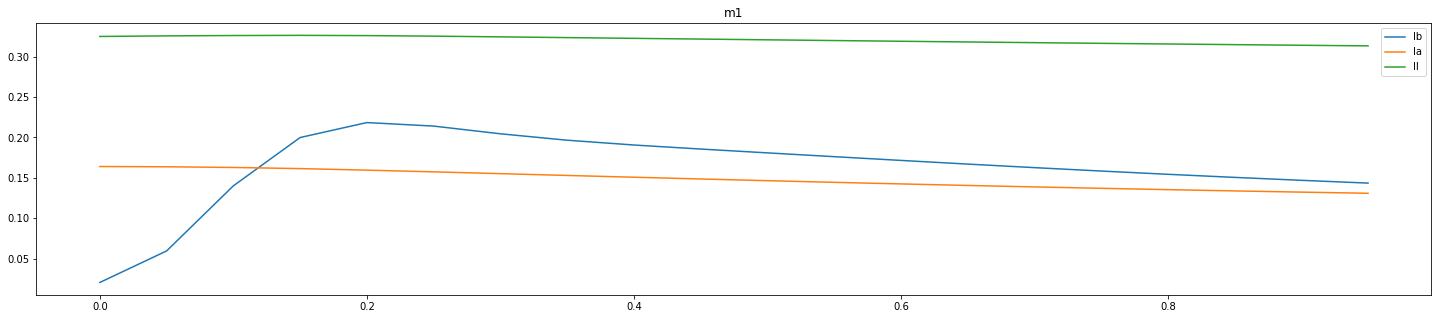

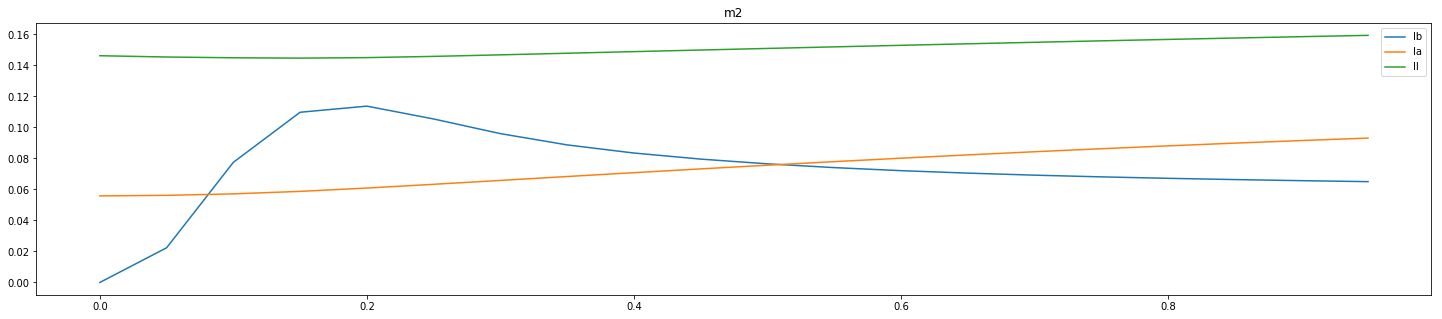

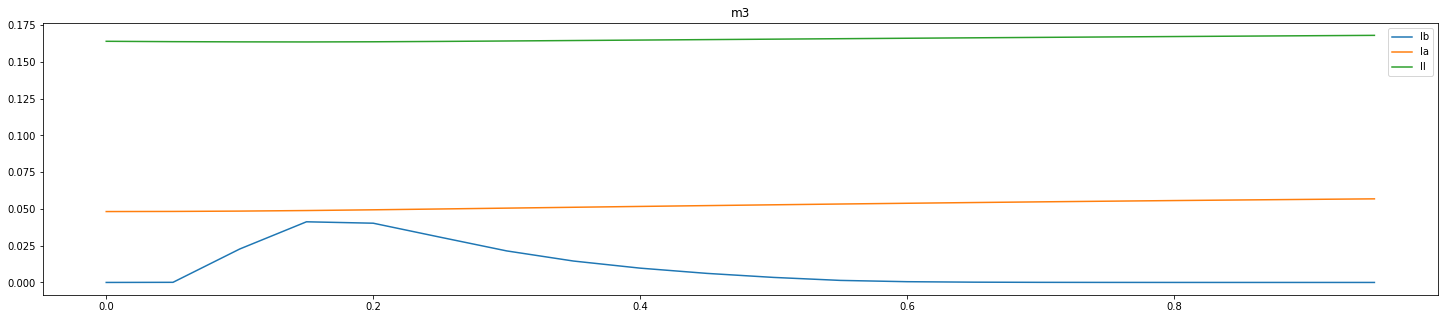

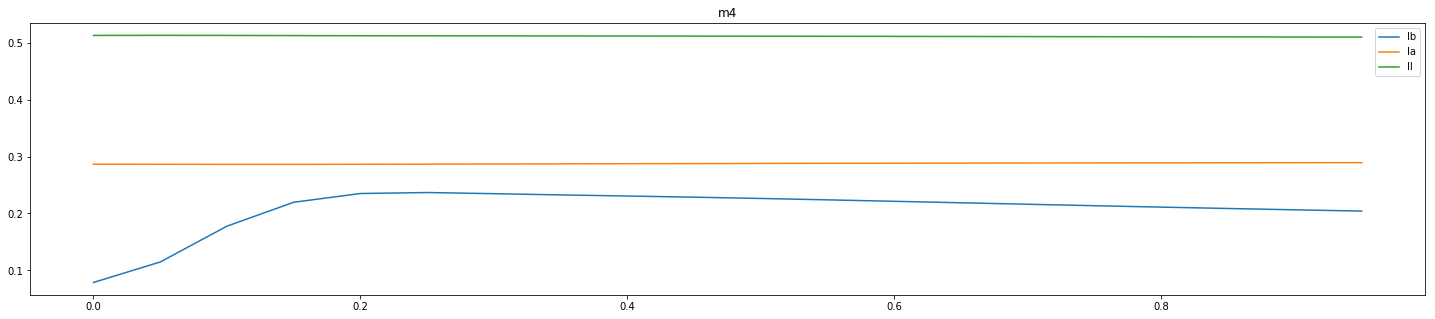

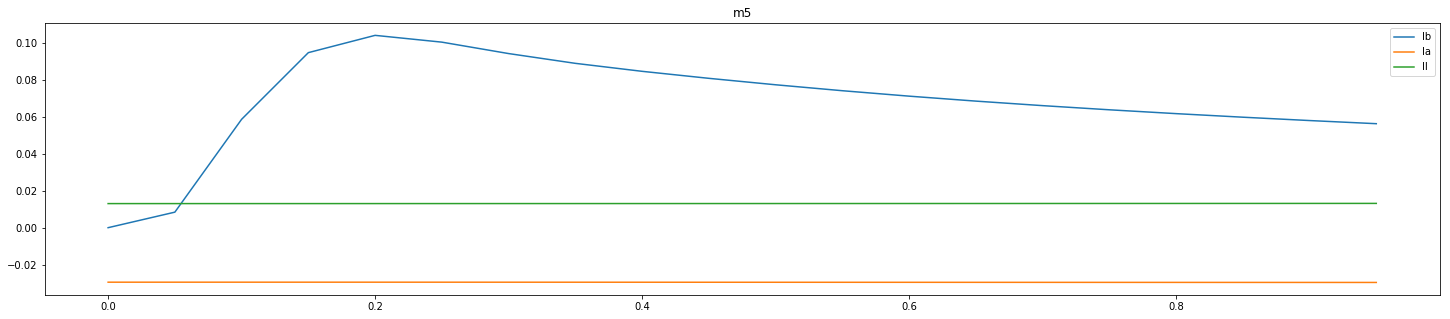

In [12]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

---

In [6]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

arm_activs = plant_data[0]
#arm_activs = all_plant_data[3]
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [8]:
# checking some connections

print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")



Connections to spinal units
0) CI (12) --> CE, w=-4.000000, port=2, plant_out=None
1) CE (7) --> CE, w=0.500000, port=1, plant_out=None
2) CI (13) --> CE, w=0.000000, port=2, plant_out=None
3) CE (8) --> CE, w=0.000000, port=1, plant_out=None
4) CI (14) --> CE, w=0.000000, port=2, plant_out=None
5) CE (9) --> CE, w=0.000000, port=1, plant_out=None
6) CI (15) --> CE, w=0.000000, port=2, plant_out=None
7) CE (10) --> CE, w=0.500000, port=1, plant_out=None
8) CI (16) --> CE, w=0.000000, port=2, plant_out=None
9) CE (11) --> CE, w=0.000000, port=1, plant_out=None
10) CI (17) --> CE, w=0.000000, port=2, plant_out=None
11) INP (18) --> CE, w=1.000000, port=0, plant_out=None
-------------------------

0) CE (6) --> CI, w=1.000000, port=2, plant_out=None
1) CE (7) --> CI, w=0.000000, port=2, plant_out=None
2) CI (13) --> CI, w=0.000000, port=1, plant_out=None
3) CE (8) --> CI, w=0.500000, port=2, plant_out=None
4) CI (14) --> CI, w=0.000000, port=1, plant_out=None
5) CE (9) --> CI, w=2.000000,

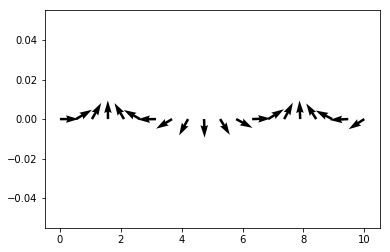

In [10]:
x = np.linspace(0,10,20)
y = np.zeros_like(x)
u = np.cos(x)
v = np.sin(x)
fig, ax = plt.subplots()
#q = ax.quiver(X, Y, U, V)
q = ax.quiver(x,y,u,v)
plt.show()

In [5]:
# SIMPLE SIMULATION
net.plants[0].place_hand([0.5, 0.15])
start_time = time.time()
times, data, plant_data  = net.flat_run(50.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 53.31408667564392 seconds
